In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from scipy.spatial import KDTree

import skeletor as sk

from skeletor.skeleton import Octree
from skeletor.data import loadTestDataset, plotTestDatasets

import tqdm

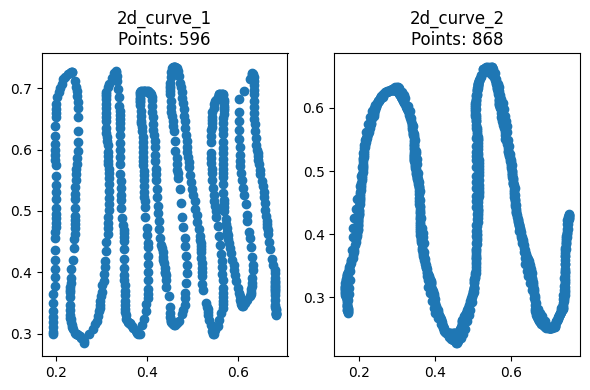

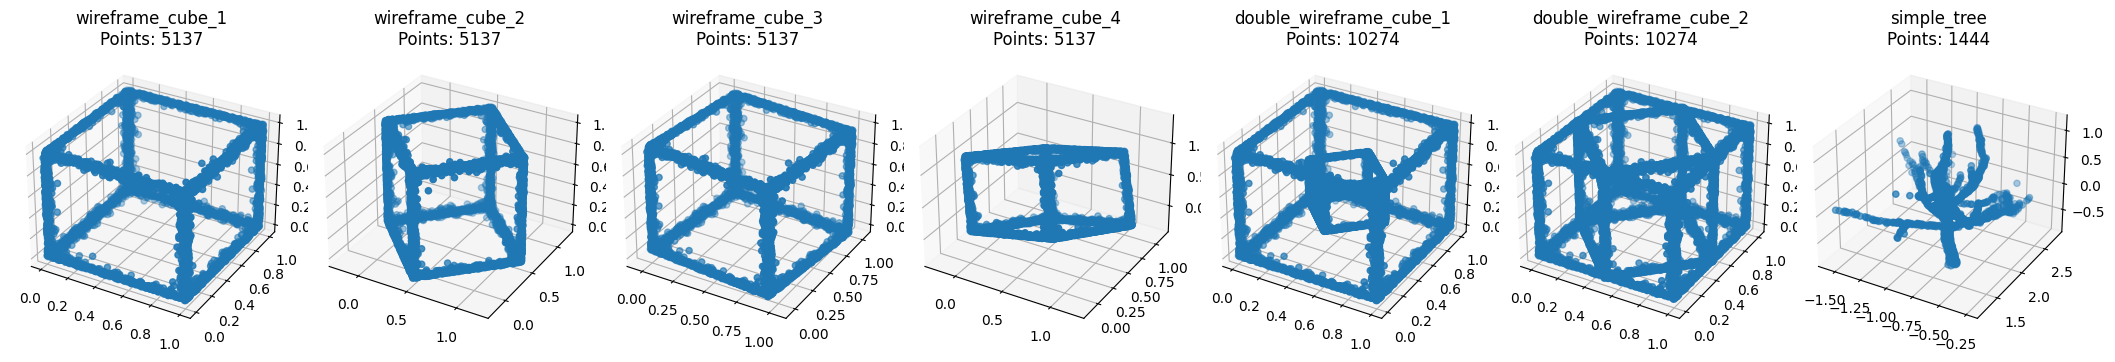

In [2]:
plotTestDatasets()

(868, 2)


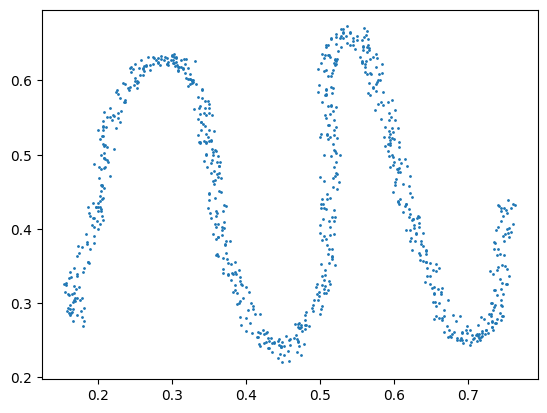

In [6]:
points = loadTestDataset('2d_curve_2', extraNoise=.02)

print(points.shape)

fig = plt.figure()
ax = fig.add_subplot(projection='3d' if points.shape[-1] == 3 else None)

ax.scatter(*points.T, s=1)
plt.show()

In [7]:
octree = Octree(points, 500, debug=True)
fig = octree.plotSkeleton(lineKwargs={'c':'black'})
fig.set_size_inches((7,7))
plt.show()

IndexError: index 2 is out of bounds for axis 1 with size 2

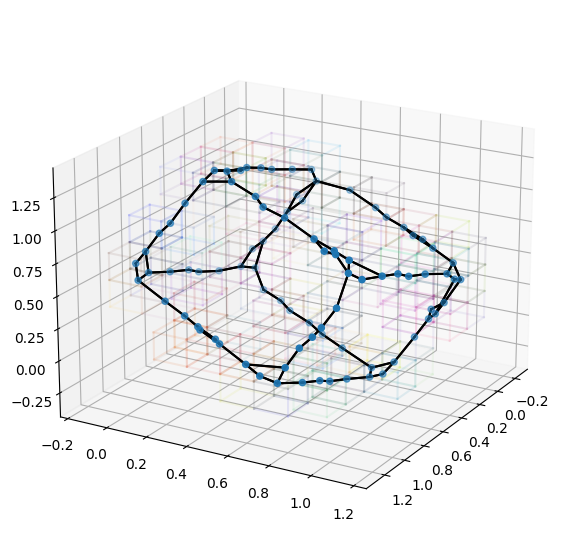

In [21]:
fig = octree.plotSkeleton(lineKwargs={'c':'black'})
fig.set_size_inches((7,7))
plt.gca().view_init(20, 30)
plt.show()

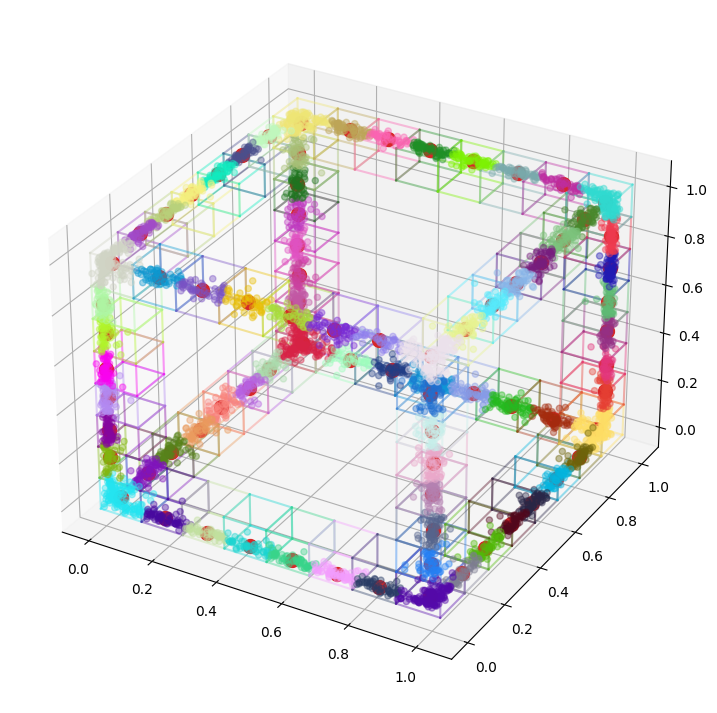

In [5]:
#%matplotlib widget
fig = octree.plot(plotBoxKwargs={'drawFaceCenters':False})
fig.set_size_inches((9,9))
plt.show()

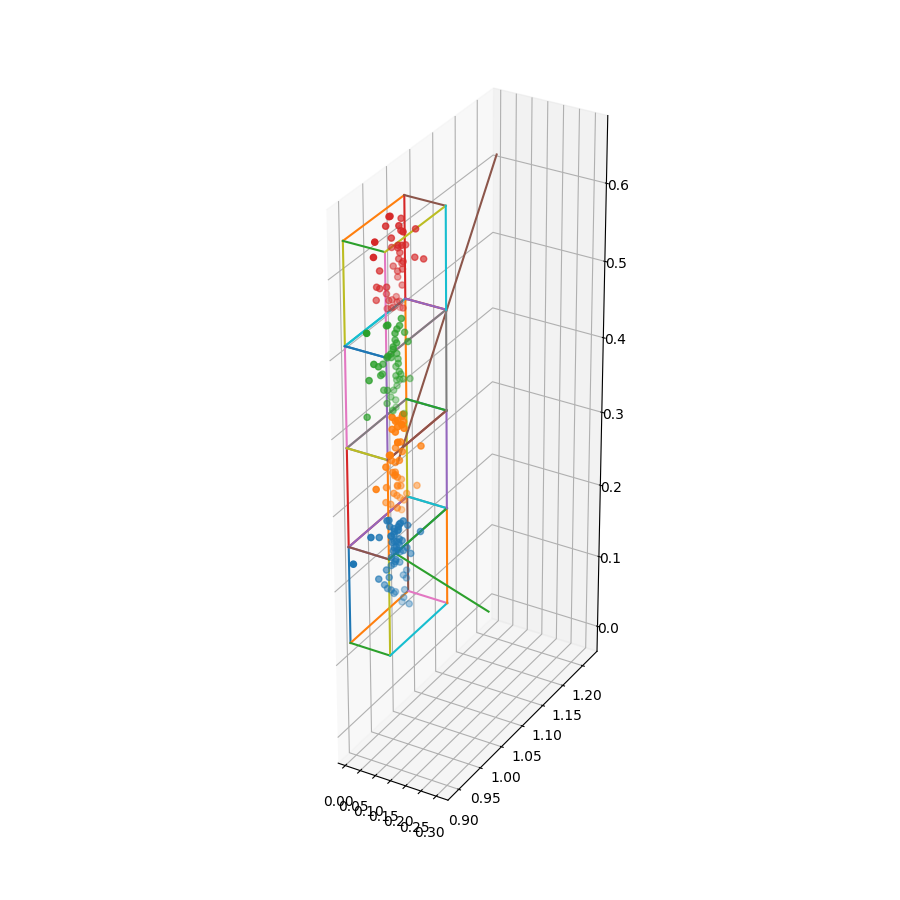

In [4]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#fig = octree.plotSkeleton()
for i in [21, 22, 23, 24]:
  octree.boxes[i].plot(ax=plt.gca(), drawBounds=True, drawPoints=True, drawFaceCenters=False, drawCentroid=False, drawMoments=True)
fig.set_size_inches((9,9))
plt.axis('square')
plt.show()

In [31]:
boxes = [octree.boxes[i] for i in [21, 22, 23]]
allFaces = np.array([fc for b in boxes for fc in b.getBoxFaceCenters()])
kdTree = KDTree(allFaces)
potentialNeighbors = kdTree.query_ball_point(allFaces, .03)
potentialNeighbors = [np.int32(np.floor(np.concatenate(potentialNeighbors[i*6:(i+1)*6])/6)) for i in range(len(boxes))]
potentialNeighbors = [np.unique(n) for n in potentialNeighbors]
print(potentialNeighbors)

[array([0, 1], dtype=int32), array([0, 1, 2], dtype=int32), array([1, 2], dtype=int32)]


In [3]:
test = np.genfromtxt('../touch_data1.csv', delimiter=',')
np.save('2d_curve_2.npy', test)

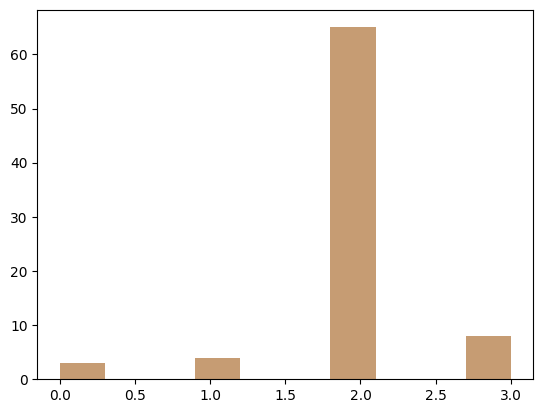

In [10]:
%matplotlib inline
points, adjMat = octree.skeleton()
plt.hist([np.sum(a) for a in adjMat], alpha=.5)
plt.hist([len(b.neighbors) for b in octree.boxes], alpha=.5)
plt.show()

In [5]:
%matplotlib inline
centroids = octree.getCentroids()
adjMat = octree.getAdjMat()

fig = plt.figure(figsize=(10, 15))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

ax1.scatter(points[:,0], points[:,1], points[:,2], s=5, alpha=.1)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')

ax2.scatter(centroids[:,0], centroids[:,1], centroids[:,2], s=1)

for i in range(len(adjMat)):
    edgeIndices = np.where(adjMat[i] > 0)[0]
    for j in range(len(edgeIndices)):
        ax2.plot(*list(zip(centroids[i], centroids[edgeIndices[j]])))

fig.tight_layout()
#plt.savefig('cube_discrete_skeleton.png')
plt.show()

AttributeError: 'Octree' object has no attribute 'getCentroids'

In [7]:
dominantDirections = []
adjMat = octree.getAdjMat()
centroids = octree.getCentroids()

for i in tqdm.tqdm(range(len(centroids))):
    hist, thetaBins, phiBins = sk.angularHistogramAroundPoint(centroids, i, adjMat, smoothing=21)
    peakDirections = sk.findDominantHistogramDirections(hist, thetaBins, phiBins, normalize=True)

    dominantDirections.append(peakDirections)

 10%|███▏                            | 11/110 [00:00<00:01, 98.49it/s]../skeletor/peak_finding.py:97: RuntimeWarning: invalid value encountered in true_divide
  peakPrevalences /= dataRange
100%|██████████████████████████████| 110/110 [00:01<00:00, 101.85it/s]


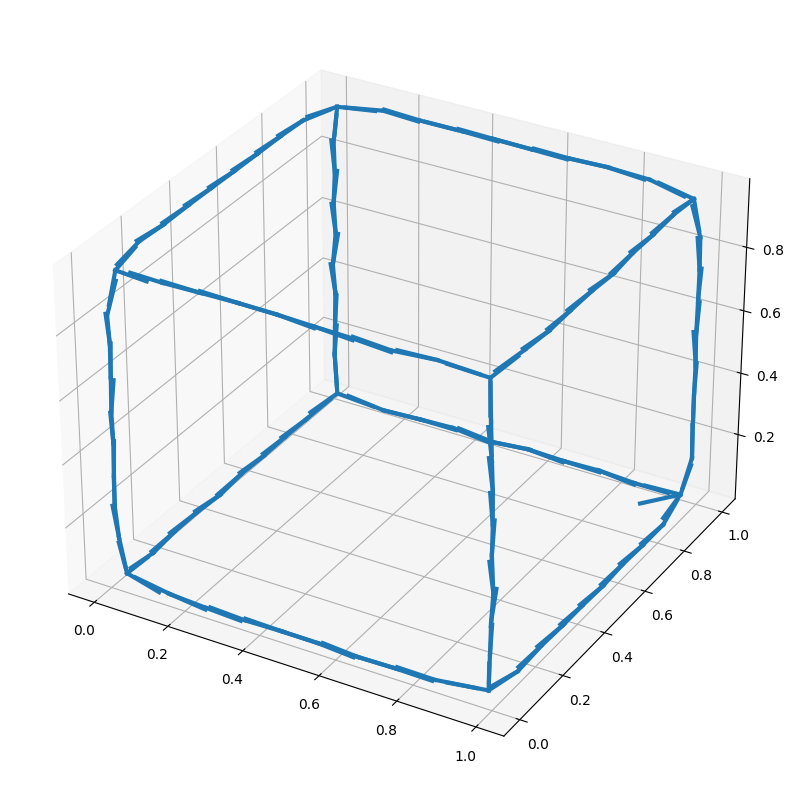

In [8]:
fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(projection='3d')

for i in range(len(centroids)):
    for j in range(len(dominantDirections[i])):
        linePoints = np.array([centroids[i], centroids[i] - .1*dominantDirections[i][j]])
        ax.plot(linePoints[:,0], linePoints[:,1], linePoints[:,2], linewidth=3, c='tab:blue')

plt.show()

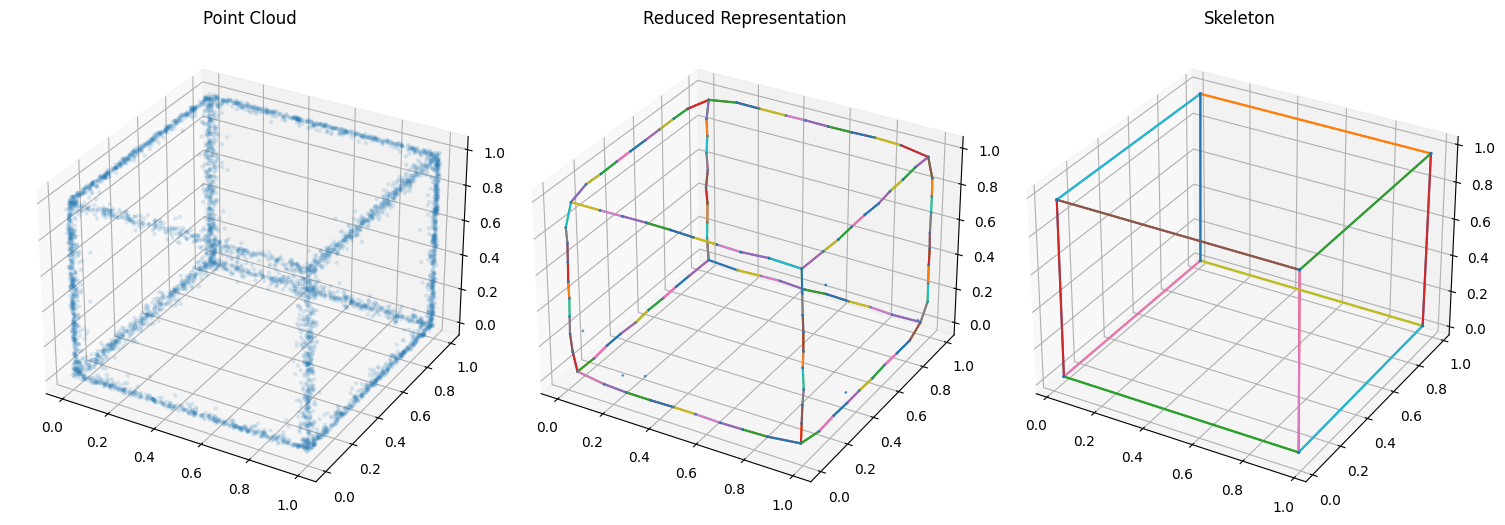

In [10]:
%matplotlib inline

skelPoints, skelAdjMat = octree.skeletonize(threshold=-.7, closed=False, mergeThreshold=1, secondRoundNeighborDetection=True, allowMergePoints=True)

centroids = octree.getCentroids()
adjMat = octree.getAdjMat()

fig = plt.figure(figsize=(15, 10))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')

ax1.scatter(points[:,0], points[:,1], points[:,2], s=5, alpha=.1)

ax2 = fig.add_subplot(1, 3, 2, projection='3d')

ax2.scatter(centroids[:,0], centroids[:,1], centroids[:,2], s=1)

for i in range(len(adjMat)):
    edgeIndices = np.where(adjMat[i] > 0)[0]
    for j in range(len(edgeIndices)):
        ax2.plot(*list(zip(centroids[i], centroids[edgeIndices[j]])))

ax3 = fig.add_subplot(1, 3, 3, projection='3d')

ax3.scatter(skelPoints[:,0], skelPoints[:,1], skelPoints[:,2], s=2, alpha=1)
for i in range(len(skelAdjMat)):
    edgeIndices = np.where(skelAdjMat[i] > 0)[0]
    for j in range(len(edgeIndices)):
        ax3.plot(*list(zip(skelPoints[i], skelPoints[edgeIndices[j]])))

ax1.set_title('Point Cloud')
ax2.set_title('Reduced Representation')
ax3.set_title('Skeleton')
        
fig.tight_layout()
#plt.savefig('cube_skeletonization.png', bbox_inches='tight')
plt.show()

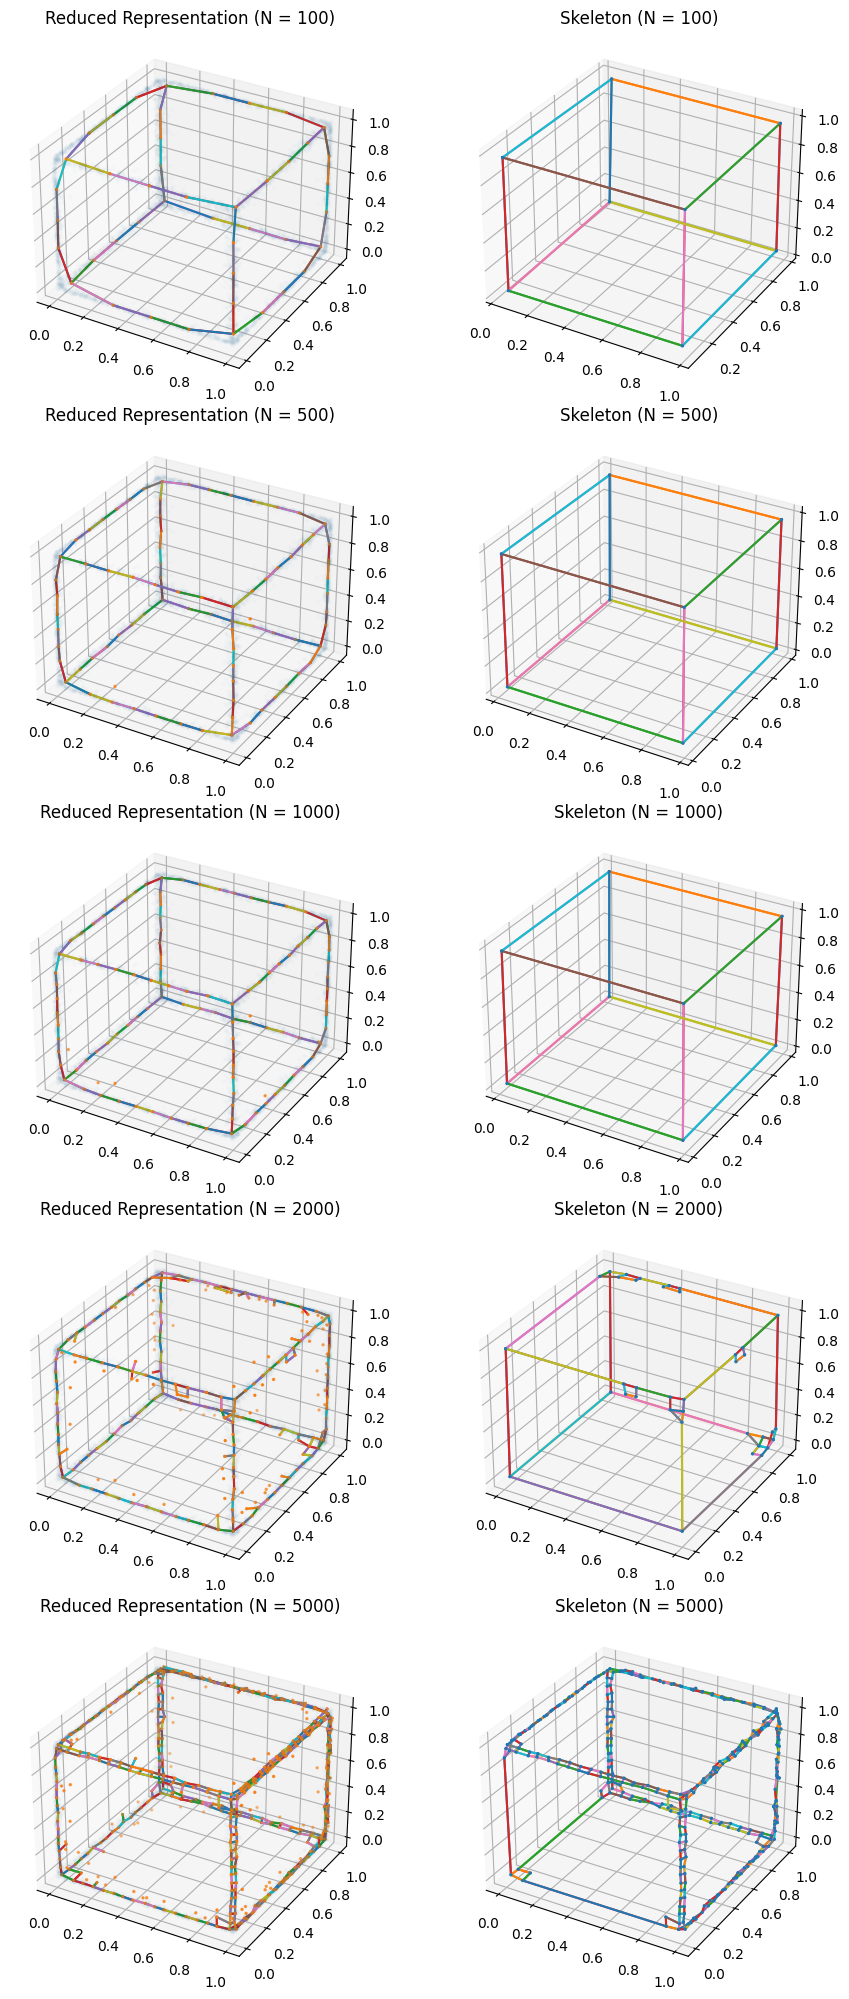

In [14]:
%matplotlib inline

fig = plt.figure(figsize=(10, 20))
nBoxesArr = [100, 500, 1000, 2000, 5000]

for k in tqdm.tqdm(range(len(nBoxesArr))):

    octree = sk.Octree(points, nBoxesArr[k], 1/128, neighborMethod='discrete')
    
    skelPoints, skelAdjMat = octree.skeletonize(threshold=-.7, closed=True, mergeThreshold=1, secondRoundNeighborDetection=True, allowMergePoints=True)

    centroids = octree.getCentroids()
    adjMat = octree.getAdjMat()


    ax1 = fig.add_subplot(len(nBoxesArr), 2, 2*k+1, projection='3d')
    
    ax1.scatter(points[:,0], points[:,1], points[:,2], s=5, alpha=.01)
    ax1.scatter(centroids[:,0], centroids[:,1], centroids[:,2], s=2)

    for i in range(len(adjMat)):
        edgeIndices = np.where(adjMat[i] > 0)[0]
        for j in range(len(edgeIndices)):
            ax1.plot(*list(zip(centroids[i], centroids[edgeIndices[j]])))

    ax2 = fig.add_subplot(len(nBoxesArr), 2, 2*k+2, projection='3d')

    ax2.scatter(skelPoints[:,0], skelPoints[:,1], skelPoints[:,2], s=2, alpha=1)
    for i in range(len(skelAdjMat)):
        edgeIndices = np.where(skelAdjMat[i] > 0)[0]
        for j in range(len(edgeIndices)):
            ax2.plot(*list(zip(skelPoints[i], skelPoints[edgeIndices[j]])))

    ax1.set_title(f'Reduced Representation (N = {nBoxesArr[k]})')
    ax2.set_title(f'Skeleton (N = {nBoxesArr[k]})')

fig.tight_layout()
#plt.savefig('cube_skeletonization.png', bbox_inches='tight')
plt.show()